# **Import Modules**

In [ ]:
!pip install -q tensorflow-io
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Lambda, Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from pathlib import Path
import tensorflow_hub as hub

from utils import DatasetBuilder ,EvaluateModel ,ModelUtils 

     |████████████████████████████████| 25.9 MB 3.1 MB/s 


# **Prepare Dataset**

In [ ]:
DATASET_PATH = os.path.join(os.getcwd(),'drive',"MyDrive", 'Car-Color-Recognition','CarDS')
BATCH_SIZE = 32
IMAGE_SIZE = (300 ,300)
colorspace = "RGB"
model_name = "RGB"
dsBuilder = DatasetBuilder(DATASET_PATH ,image_size = IMAGE_SIZE ,batch_size = BATCH_SIZE)
train_ds , val_ds = dsBuilder.create('train') , dsBuilder.create('val')
class_names=train_ds.class_names
NUM_CLASSES = len(class_names)

class_weights = dsBuilder.get_class_weights(train_ds)

for key ,value in class_weights.items() : print("{} : {}".format(class_names[key], value.round(3)))

Found 19171 files belonging to 16 classes.
Found 3491 files belonging to 16 classes.
beige : 1.161
black : 0.97
blue : 1.087
brown : 1.14
cream : 2.014
crimson : 1.945
gold : 2.147
green : 1.325
grey : 0.873
navy-blue : 2.031
orange : 1.39
red : 1.152
silver : 1.268
titanium : 1.997
white : 0.209
yellow : 1.297


In [ ]:
train_ds = (
    train_ds.
    map(lambda img, lbl: (img/255., lbl), num_parallel_calls=tf.data.AUTOTUNE).
    prefetch(tf.data.AUTOTUNE))

val_ds = (
    val_ds.
    map(lambda img, lbl: (img/255., lbl), num_parallel_calls=tf.data.AUTOTUNE).
    prefetch(tf.data.AUTOTUNE))

# **Augmentation**

In [ ]:
augmentation = Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomZoom(0.05),
    ]
)

# **Visualize Data**

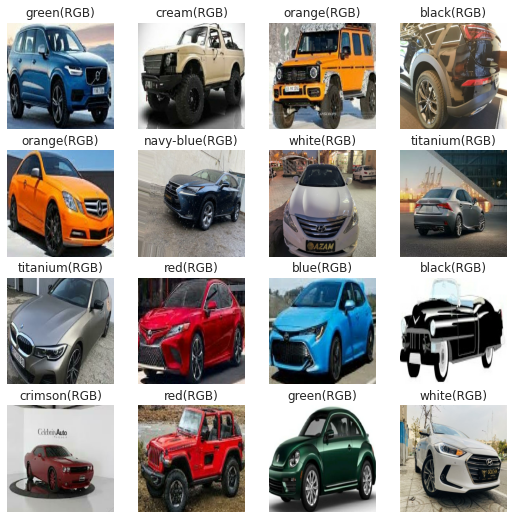

In [ ]:
fig=plt.figure(figsize=(9, 9))
for images, labels in train_ds.take(1):
    for i in range(16):
      plt.subplot(4, 4, i + 1)
      color_space = "RGB"
      image = tf.expand_dims(images[i] ,axis=0)
      #image = tf.cast(image * 255.0, tf.uint8)
      lbl = "{}({})".format(class_names[labels[i].numpy().argmax()] , color_space )
      plt.imshow(tf.squeeze(image))
      plt.title(lbl)
      plt.axis("off")
    break

# **Build and Train Model**

In [ ]:
do_fine_tuning = True

url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2"
base_model = hub.KerasLayer(url,trainable=do_fine_tuning)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    augmentation,
    base_model,
    Dense(400),
    Dropout(0.3),
    tf.keras.layers.Dense(NUM_CLASSES,activation = "softmax", kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1536)              12930622  
                                                                 
 dense (Dense)               (None, 400)               614800    
                                                                 
 dropout (Dropout)           (None, 400)               0         
                                                                 
 dense_1 (Dense)             (None, 16)                6416      
                                                                 
Total params: 13,551,838
Trainable params: 13,442,622
Non-trainable params: 109,216
_________________________________________________________________


In [ ]:
model_utils = ModelUtils(model_name ,"HUB")
run_index = 1
callbacks= model_utils.get_callbacks(run_index = run_index )
model = model_utils.make_or_restore_model(model,"SGD",lr = 1e-2)
n_epochs = 50
print("{}: ".format(model_name))
model.fit(train_ds,
          validation_data=val_ds,
          epochs=n_epochs,
          callbacks=callbacks,
          class_weight = class_weights
          )  

Creating a new model
RGB: 
Epoch 1/50
600/600 [==============================] - ETA: 0s - loss: 0.8664 - accuracy: 0.7328
Epoch 1: val_loss improved from inf to 0.94066, saving model to /content/drive/MyDrive/Car-Color-Recognition/Callbacks/Checkpoints/RGB/_1.h5
600/600 [==============================] - 3881s 6s/step - loss: 0.8664 - accuracy: 0.7328 - val_loss: 0.9407 - val_accuracy: 0.7227 - lr: 0.0100
Epoch 2/50
600/600 [==============================] - ETA: 0s - loss: 0.4829 - accuracy: 0.8474
Epoch 2: val_loss improved from 0.94066 to 0.68113, saving model to /content/drive/MyDrive/Car-Color-Recognition/Callbacks/Checkpoints/RGB/_2.h5
600/600 [==============================] - 380s 632ms/step - loss: 0.4829 - accuracy: 0.8474 - val_loss: 0.6811 - val_accuracy: 0.7889 - lr: 0.0100
Epoch 3/50
600/600 [==============================] - ETA: 0s - loss: 0.3755 - accuracy: 0.8797
Epoch 3: val_loss did not improve from 0.68113
600/600 [==============================] - 379s 629ms/step

In [ ]:
model_utils.save_model_and_history(model ,run_index)

INFO:tensorflow:Assets written to: ram://abd30fcc-0409-4e2c-adb5-f25f204b8cc7/assets


INFO:tensorflow:Assets written to: ram://abd30fcc-0409-4e2c-adb5-f25f204b8cc7/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Car-Color-Recognition/Models/RGB/1/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Car-Color-Recognition/Models/RGB/1/assets


In [ ]:
model = keras.models.load_model("/content/drive/MyDrive/Car-Color-Recognition/Callbacks/Checkpoints/RGB/_11.h5" ,custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
eval = EvaluateModel(model ,val_ds ,class_names,"RGB")

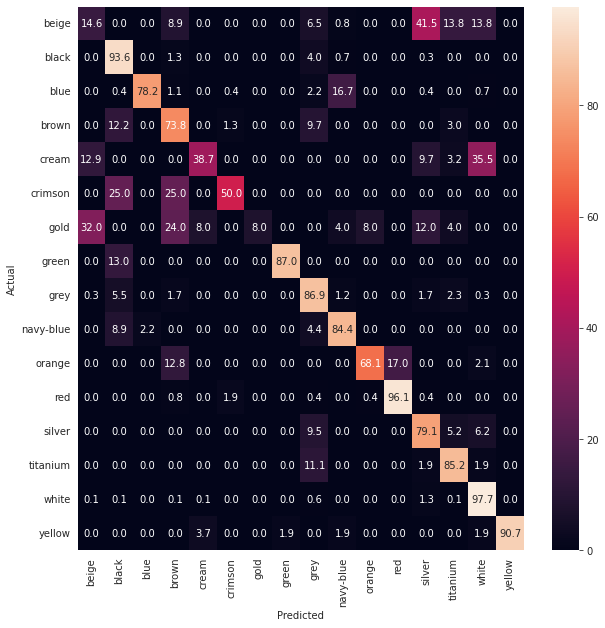

In [ ]:
eval.plot_confusion()

In [ ]:
eval.report()

Report CSV file added to logs .


,precision,recall,f1-score,support
beige,0.562500,0.146341,0.232258,123.0000
black,0.818182,0.936242,0.873239,298.0000
blue,0.995370,0.781818,0.875764,275.0000
brown,0.810185,0.738397,0.772627,237.0000
cream,0.705882,0.387097,0.500000,31.0000
crimson,0.307692,0.500000,0.380952,8.0000
gold,1.000000,0.080000,0.148148,25.0000
green,0.975610,0.869565,0.919540,46.0000
grey,0.774026,0.868805,0.818681,343.0000
navy-blue,0.408602,0.844444,0.550725,45.0000
